# 1. Configuración del Ambiente

In [1]:
#@title
#Definimos las variables globales que se usarán en el notebook
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision
#Importamos las librerias necesarias para el proyecto
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import time
import datetime
from IPython.display import clear_output

In [2]:
#Verificamos que se tengan las versiones correctas de cada librería
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


# 2. Obtención de datos

##2.1 Precios Históricos del Bitcoin

In [3]:
#@title
def importar_base_bitcoin():
  global df_bitcoin
  df_bitcoin = yf.download("BTC-USD", period="7d", interval="5m")

In [4]:
#Muestra de la base histórica de precios del Bitcoin
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-17 00:00:00+00:00,28522.097656,28540.667969,28514.380859,28540.667969,28540.667969,0
2023-10-17 00:05:00+00:00,28546.552734,28559.431641,28512.556641,28512.556641,28512.556641,24692736
2023-10-17 00:10:00+00:00,28512.556641,28512.556641,28499.109375,28499.109375,28499.109375,20992000
2023-10-17 00:15:00+00:00,28484.177734,28484.177734,28463.269531,28463.269531,28463.269531,0
2023-10-17 00:20:00+00:00,28465.617188,28472.287109,28465.617188,28472.287109,28472.287109,14622720


##2.2 Indicadores de Tendencias

In [5]:
#@title
def extraer_tendencias():
  global precio_actual, tendencia
  headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'}
  url = "https://coinmarketcap.com/"
  respuesta = requests.get(url, headers=headers)
  s = BeautifulSoup(respuesta.content, "lxml")
  respuesta = s.findAll('p', {'class':'sc-4984dd93-0 iqdbQL coin-item-symbol'})

  indice=0
  for item in respuesta:
    if item.getText()=='BTC':
      break
    indice+=1

  respuesta = s.findAll('div', {'class':['sc-a0353bbc-0 gDrtaY', 'sc-a0353bbc-0 gDrtaY fall', 'sc-a0353bbc-0 gDrtaY rise']})
  precio_actual = float(respuesta[indice].getText().replace('$','').replace(',',''))

  lista = []
  respuesta = s.findAll('span', {'class':['sc-d55c02b-0 iwBxy', 'sc-d55c02b-0 gUnzUB']})
  for item in respuesta[::3]:
    lista.append(item)

  tendencia = ''
  if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
    tendencia = 'baja'
  else:
    tendencia = 'alta'

In [6]:
#Muestra del Precio Actual del Bitcoin y su tendencia
extraer_tendencias()
print('Bitcoin Price: ', precio_actual)
print('Tendencia: ', tendencia)

Bitcoin Price:  30351.66
Tendencia:  baja


#3. Limpieza de datos

In [7]:
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1742 entries, 2023-10-17 00:00:00+00:00 to 2023-10-23 02:40:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1742 non-null   float64
 1   High       1742 non-null   float64
 2   Low        1742 non-null   float64
 3   Close      1742 non-null   float64
 4   Adj Close  1742 non-null   float64
 5   Volume     1742 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.3 KB
None


,Open,High,Low,Close,Adj Close,Volume
count,1742.0,1742.0,1742.0,1742.0,1742.0,1742.0
mean,29090.0,29102.0,29079.0,29091.0,29091.0,18931901.0
std,696.0,697.0,695.0,696.0,696.0,50011251.0
min,28126.0,28156.0,28110.0,28130.0,28130.0,0.0
25%,28413.0,28422.0,28403.0,28413.0,28413.0,0.0
50%,28755.0,28773.0,28740.0,28757.0,28757.0,0.0
75%,29824.0,29837.0,29811.0,29822.0,29822.0,16042752.0
max,30421.0,30521.0,30399.0,30399.0,30399.0,623319040.0


<Axes: >

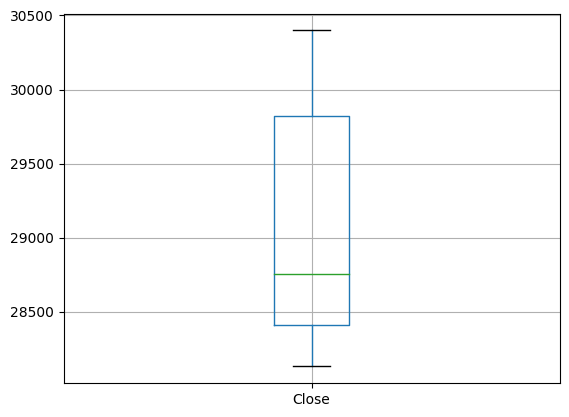

In [8]:
#Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close'])

In [9]:
#@title
def limpieza_datos():
  global df_bitcoin, df_bitcoin_limpio, media_bitcoin
  #Comenzaremos creando una copia del dataframe original
  df_bitcoin_limpio = df_bitcoin.copy()

  #Ahora trataremos los datetime que funcionan como índices para que no se repitan
  seleccion = df_bitcoin.index.isin(df_bitcoin.index.unique())
  df_bitcoin_limpio = df_bitcoin[seleccion]

  #Procederemos a tratar los elementos que son NA de la columna Close, eliminándolos para que no afecten al dataframe
  #Es mejor eliminarlos puesto que en caso de existir algun NA, no tendría sentido para el trading y demás cálculos y si los reemplazamos con
  #0 o la media en el momento, alteraríamos la media de nuevo, haciendo que nuestras decisiones no sean con datos correctos.
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)

  #Queremos limpiar también los datos cuyo Volume es 0, eliminándolos del dataframe
  seleccion = df_bitcoin_limpio['Volume'] > 0
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  #Procederemos a eliminar outliers para quedarnos solo con los valores adecuados
  valor = df_bitcoin_limpio['Close']
  Q1 = valor.quantile(.25)
  Q3 = valor.quantile(.75)
  seleccion = ((valor >= Q1) & (valor <= Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  #Finalmente con el nuevo dataframe limpio procedemos a calcular la media del mismo
  media_bitcoin = df_bitcoin_limpio['Close'].mean().round(2)

<Axes: >

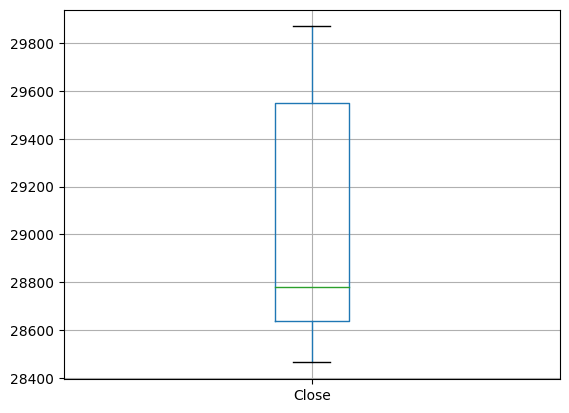

In [10]:
#Muestra el Boxplot de la base limpia
limpieza_datos()
df_bitcoin_limpio.boxplot(['Close'])

In [11]:
#Muestra el precio promedio de la base limpia
print('Precio Promedio Bitcoin: ', media_bitcoin)

Precio Promedio Bitcoin:  29054.31


#4. Tomar decisiones

In [12]:
#@title
def tomar_decisiones():
  global algoritmo_decision
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

In [13]:
#Mostramos la decisión del algoritmo
tomar_decisiones()
print('Precio Promedio Bitcoin: ', media_bitcoin)
print('Precio Actual Bitcoin: ', precio_actual)
print('Tendencia: ', tendencia)
print('Decisión del algoritmo: ', algoritmo_decision)

Precio Promedio Bitcoin:  29054.31
Precio Actual Bitcoin:  30351.66
Tendencia:  baja
Decisión del algoritmo:  Vender


#5. Visualización

In [14]:
#@title
def visualizacion():
  global df_bitcoin, media_bitcoin, algoritmo_decision, precio_actual, tendencia
  df_bitcoin['Promedio'] = media_bitcoin
  plt.rc('figure', figsize = (16,5))
  plt.suptitle('Precio del Bitcoin ($)', ha='left', x=0.13, y=0.94, fontweight ="bold")
  plt.plot(df_bitcoin.index, df_bitcoin['Close'])
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'])
  plt.annotate(algoritmo_decision, xy=(0.9, 0.9), xycoords='axes fraction', size=14)
  clear_output()
  print('Hora de ejecución: ', datetime.datetime.now())
  print('Precio Promedio Bitcoin: ', media_bitcoin)
  print('Precio Actual Bitcoin: ', precio_actual)
  print('Tendencia: ', tendencia)
  plt.show()

Hora de ejecución:  2023-10-23 02:44:49.325287
Precio Promedio Bitcoin:  29054.31
Precio Actual Bitcoin:  30351.66
Tendencia:  baja


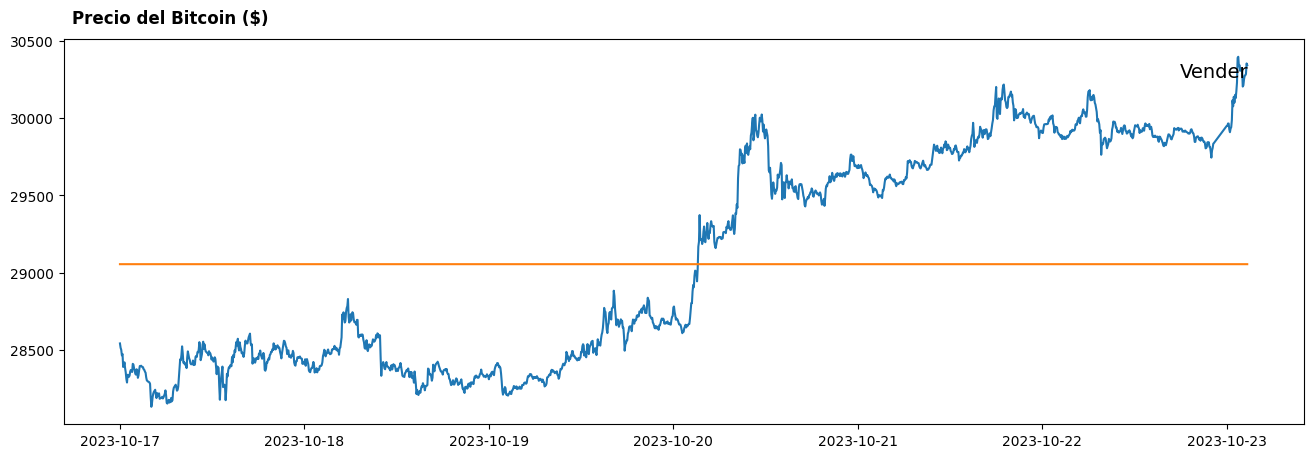

In [15]:
#Mostramos el resultado de la toma de decisiones gráficamente
visualizacion()

#6. Automatización

Hora de ejecución:  2023-10-23 02:44:50.336438
Precio Promedio Bitcoin:  29054.31
Precio Actual Bitcoin:  30351.66
Tendencia:  baja


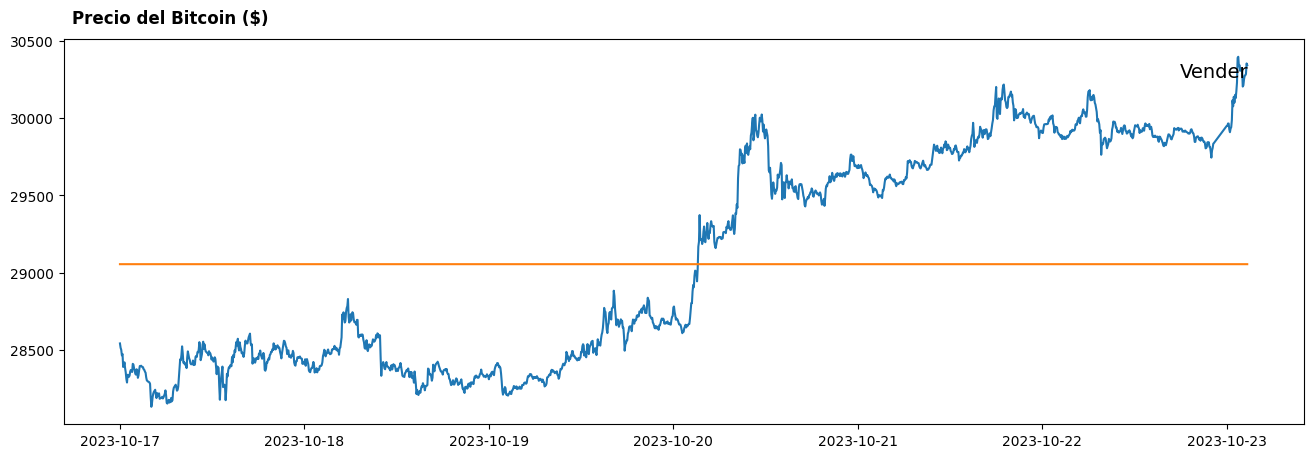

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)